In [1]:
# OpenCV(cv2): 이미지 처리
import cv2
# 그래프 그리기
from matplotlib import pyplot as plt
# 배열 연산
import numpy as np
# 머신러닝 패키지
# train_test_split라는 메소드를 사용. 데이터 셋을 트레이닝 셋과 테스트 셋으로 분리해줌
from sklearn.model_selection import train_test_split
# 데이터 프레임 (엑셀과 비슷) 텍스트 파일을 하나 읽기 위해서
import pandas as pd

# keras를 설치
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import datetime
import os, sys, glob

Using TensorFlow backend.


In [2]:
labels = pd.read_csv('dataset/train_test_files/All_labels.txt', sep=" ", header=None)
labels.head()


,0,1
0,CF437.jpg,2.883333
1,AM1384.jpg,2.466667
2,AM1234.jpg,2.150000
3,AM1774.jpg,3.750000
4,CF215.jpg,3.033333


In [3]:
# df.describe() 데이터셋의 통계적인 개요를 출력한다.
# 5500개의 데이터 셋이 있고, 뷰티 스코어의 평균은 2.99
# 데이터 셋의 형태를 확인
labels.describe()

,1
count,5500.000000
mean,2.990891
std,0.688112
min,1.016667
25%,2.500000
50%,2.833333
75%,3.533333
max,4.750000


In [4]:
# df.values , dataframe을 numpy 배열로 변환한다.
labels_np = labels.values
print(labels_np[:5])

[['CF437.jpg' 2.8833330000000004]
 ['AM1384.jpg' 2.4666669999999997]
 ['AM1234.jpg' 2.15]
 ['AM1774.jpg' 3.75]
 ['CF215.jpg' 3.0333330000000003]]


In [5]:
#이미지를 불러와 전처리한 후 레이블과 묶어서 numpy 형태로 변환한다.
# 이미지의 크기는 350 * 350 * 3(RGB)
# np.empty() 지정된 크기로 빈 배열을 만든다
imgs = np.empty((len(labels_np), 350, 350, 3), dtype=np.uint8)

for i, (img_filename, rating) in enumerate(labels_np):
    # labels_np을 enumerate 돌면서 cv2.imread() 이미지 파일을 로드한다
    img = cv2.imread(os.path.join('./dataset/Images', img_filename))
    
    # 이미지의 크기가 맞는지 체크해준다
    if img.shape[0] != 350 or img.shape[1] != 350:
        print(img_filename)
    imgs[i] = img

In [6]:
# train_test_split() 트레이닝 셋과 테스트 셋으로 분리한다
# test_size = 0.1 : 전체 데이터셋의 90%를 학습에 사용하고 10%를 테스트에 사용
x_train, x_val, y_train, y_val = train_test_split(imgs, labels_np[:, 1], test_size=0.1)
# 재사용을 위해 np.save() 배열을 npy파일로 저장한다
np.save('np_data/x_train.npy', x_train)
np.save('np_data/x_val.npy', x_val)
np.save('np_data/y_train.npy', y_train)
np.save('np_data/y_val.npy', y_val)
# Shape확인
# 학습 데이터 4950개, 검증 데이터 550개, 총 5500개
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(4950, 350, 350, 3) (550, 350, 350, 3)
(4950,) (550,)


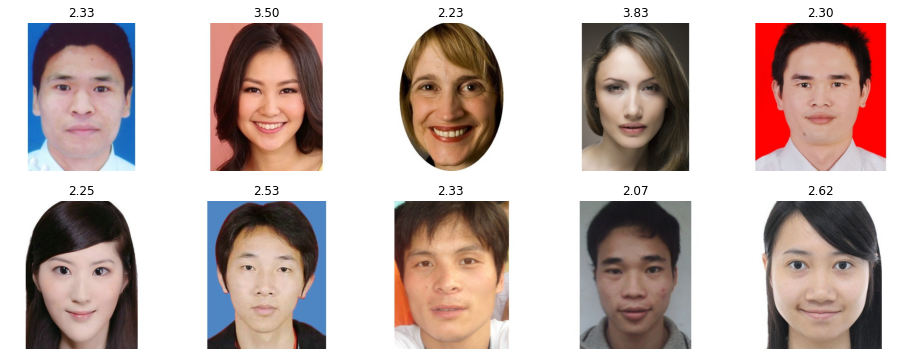

In [7]:
# 데이터 셋이 어떻게 구성되어있는지 확인
plt.figure(figsize=(16, 6))
for i, img in enumerate(x_train[:10]):
    # 10개 확인
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    # title 에 뷰티 스코어를 소수점 둘째자리까지만
    plt.title('%.2f' % y_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [9]:
# ImageDataGenerator를 통해 augmentation 시켜줌
# ImageDataGenerator를 통해 오버피팅을 방지할 수 있다. 
train_datagen = ImageDataGenerator(
    # image는 0~255의 값을 갖고 있는데 이것을 0~1사이로 바꾸는 것
    rescale=1./255,
    # -30 ~ 30도 만큼 이미지를 기울이겠다. 랜덤으로
    rotation_range=50,
    # 넓이 늘려보기
    width_shift_range=0.30,
    # 높이 늘려보기
    height_shift_range=0.30,
    # 이미지를 약간 찌그려트리기
    shear_range=0.2,
    # 이미지 확대 축소
    zoom_range=0.4,
    # 이미지를 가로 방향으로 
    horizontal_flip=True
)

# val_datagen은 할 필요 없으니까 rescale만
val_datagen = ImageDataGenerator(
    rescale=1./255
)
# flow()
# 배치 크기만큼 데이터를 생성하는 제너레이터(생성기)
# 배치 사이즈가 32이인..!
train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    # train은 shuffle 시켜줌
    shuffle=True
    
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

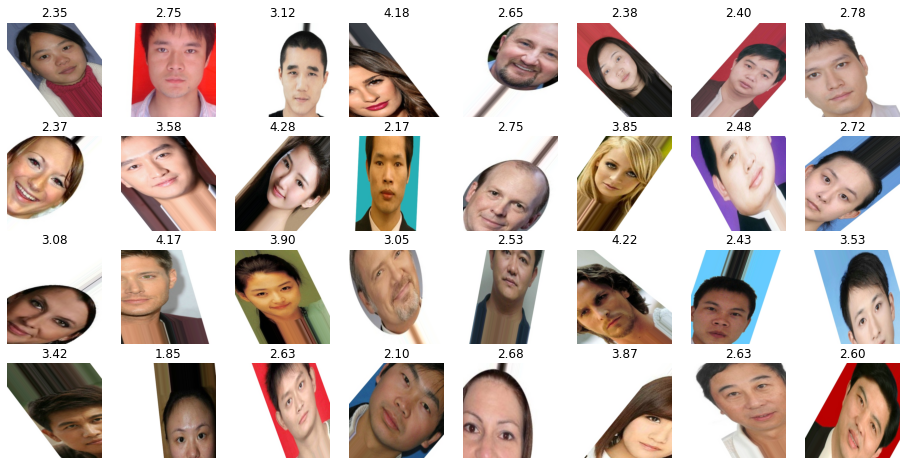

In [10]:
# 어떻게 augmentation되었는지 확인해본다.
# train_generator에서 8번째 배치를 받아온다. 
# generator.__getitem__(n) n번째 배치의 데이터를 생성한다
augs = train_generator.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    # 루프를 돌면서 32개의 이미지를 찍어본다
    plt.subplot(4, 8, i+1)
    # 타이틀에는 뷰티 스코어 , 소숫점 두번째까지
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

In [11]:
len(train_generator)

155

## Model build

In [12]:
inputs = Input(shape=(350, 350, 3))

# 1번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)


# 2번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)



# 3번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)

# 4번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)

# 5번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)

# 6번
net = Conv2D(32, kernel_size=3, strides=1, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2)(net)
net = Dropout(0.2)(net)


net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 350, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 350, 350, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 175, 175, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 175, 175, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 175, 175, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 87, 87, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 87, 87, 32)        0   

## Train model

In [13]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

history = model.fit_generator(
    # epochs 반복학습 횟수
    train_generator, epochs=10, validation_data=val_generator,
    callbacks=[
        # val_loss가 가장 낮은 것을 models/%s.h5에다가 저장
        # ModelCheckpoint() 모델을 파일로 저장하는 콜백
        # ModelCheckpoint -> pretrained models: fine-tuning을 위해 ConvNet의 checkpoint를 배포하기도 함
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    ]
)

Epoch 1/10
155/155 [==============================] - 306s 2s/step - loss: 0.6977 - val_loss: 1.4283

Epoch 00001: val_loss improved from inf to 1.42835, saving model to models/2020_06_11_12_08_59.h5
Epoch 2/10
155/155 [==============================] - 272s 2s/step - loss: 0.5734 - val_loss: 0.5420

Epoch 00002: val_loss improved from 1.42835 to 0.54200, saving model to models/2020_06_11_12_08_59.h5
Epoch 3/10
155/155 [==============================] - 269s 2s/step - loss: 0.5355 - val_loss: 0.5049

Epoch 00003: val_loss improved from 0.54200 to 0.50493, saving model to models/2020_06_11_12_08_59.h5
Epoch 4/10
155/155 [==============================] - 263s 2s/step - loss: 0.5288 - val_loss: 0.5966

Epoch 00004: val_loss did not improve from 0.50493
Epoch 5/10
155/155 [==============================] - 267s 2s/step - loss: 0.5271 - val_loss: 0.5609

Epoch 00005: val_loss did not improve from 0.50493
Epoch 6/10
155/155 [==============================] - 262s 2s/step - loss: 0.5117 - va

[0.6977765210951218, 0.5732310394084815, 0.5356153009756647, 0.5288574676080183, 0.5270895488334425, 0.5117029000893988, 0.5058756847333427, 0.5009962457358235, 0.5033145118361771, 0.505425832765271]
[1.4283480644226074, 0.5419993996620178, 0.5049349665641785, 0.5966117978096008, 0.5608757734298706, 0.6294409036636353, 0.5875834822654724, 0.7309942245483398, 0.8005824089050293, 0.599154531955719]


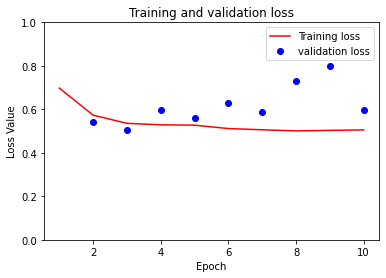

In [14]:
#plot 확인

loss = history.history['loss']
val_loss = history.history['val_loss']
print(loss)
print(val_loss)

epochs = range(1, len(loss)+1)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend()
plt.show()

## Evaluate model

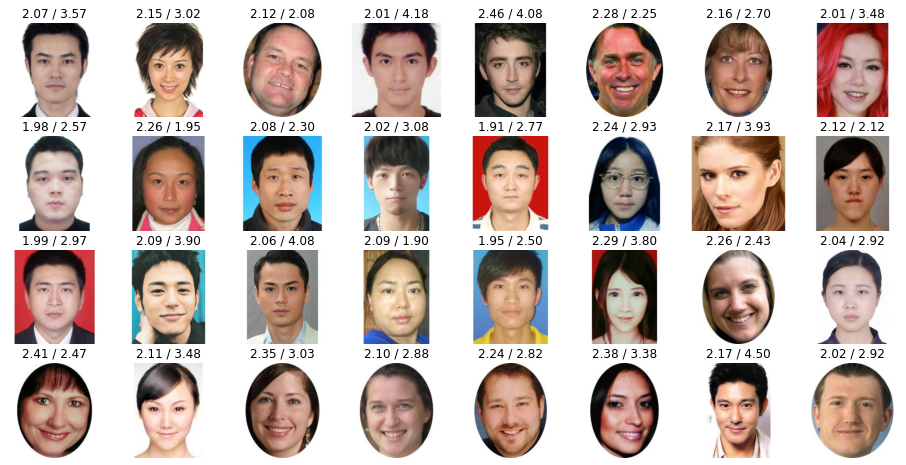

In [15]:
# load_model() 모델을 로드한다
model = load_model('models/2020_06_11_12_08_59.h5')

# __getitem__(0) 0번째 배치 불러옴
val_data = val_generator.__getitem__(0)

# model.predict() 모델로 데이터를 예측한다
preds = model.predict(val_data[0])

plt.figure(figsize=(16, 8))
for i, img in enumerate(val_data[0]):
    plt.subplot(4, 8, i+1)
    # 예측값과 정답값 확인
    plt.title('%.2f / %.2f' % (preds[i], val_data[1][i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

## Test model

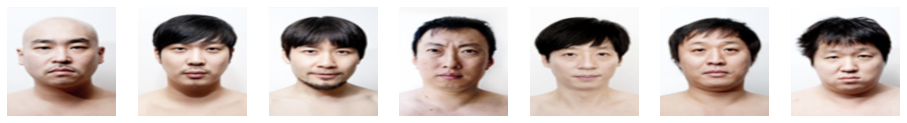

In [16]:
# glob.glob() 해당 경로의 파일 리스트를 생성한다.
img_test_list = glob.glob('img/*.png')

imgs_test_resized = []

plt.figure(figsize=(16, 8))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (350, 350))

    plt.subplot(1, len(img_test_list), i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

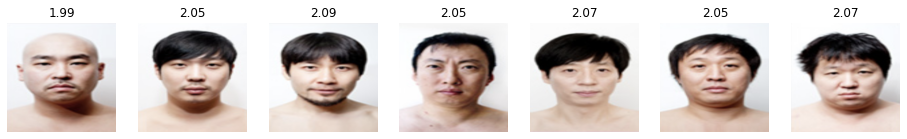

In [17]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(1, len(imgs_test_resized), i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())